In [5]:
# Imports
from mpopt import mp
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# Configure plotting style
plt.rcParams['figure.figsize'] = [12, 10]
sns.set_theme()
sns.set_style("whitegrid")

In [127]:
# Sigmoid transition function
def smooth_step(val1, val2, thresh, width, val):
    return val1 + (val2 - val1) / (1 + np.exp(-(val - thresh) * 5 / width))

In [228]:
# Define OCP
ocp = mp.OCP(n_states=4, n_controls=1, n_phases=1)

# Define dynamics
ocp.dynamics[0] = lambda x, u, t: [
    smooth_step(25, -25, np.deg2rad(-35), np.deg2rad(5), x[1]) - (u[0] - x[1]),
    1 * (u[0] - x[1]),
    x[0] * np.cos(x[1]),
    x[0] * np.sin(x[1])
]

# Objective
ocp.terminal_costs[0] = lambda xf, tf, x0, t0: tf

# Terminal constraints
ocp.terminal_constraints[0] = lambda xf, tf, x0, t0: [
    xf[2] - 20000,
    xf[3] - 0
]

# Initial conditions
ocp.x00[0] = [
    1200,
    0.0,
    0.0,
    10000
]

# Control constraints
ocp.lbu[0] = -np.pi/2
ocp.ubu[0] =  0

# State constraints
ocp.lbx[0][0] = 1000
ocp.ubx[0][0] = 1400

# Scales
ocp.scale_x = [
    1 / 1000,
    1 / np.deg2rad(90),
    1 / 20000,
    1 / 10000
]

# Validate OCP
ocp.validate()

# Solve OCP
mpo = mp.mpopt_adaptive(ocp, 25, 3)
mpo.mid_residuals=True
solution = mpo.solve(nlp_solver_options={'ipopt.print_level': 3, 'ipopt.max_iter': 5000})
post = mpo.process_results(solution, plot=False)
x, u, t = post.get_data(interpolate=False)

Total number of variables............................:      402
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      176
                     variables with only upper bounds:        0
Total number of equality constraints.................:      307
Total number of inequality constraints...............:      675
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      450
        inequality constraints with only upper bounds:        0


Number of Iterations....: 1729

                                   (scaled)                 (unscaled)
Objective...............:  2.4531144496309608e+001   2.4531144496309608e+001
Dual infeasibility......:  9.9999769618377643e-001   9.9999769618377643e-001
Constraint violation....:  6.5368267810911318e-004   6.5368267810911318e-004
Complementarity.........:  2.5059205023092874e-009   2.5059205023092874e-009
Overall NLP

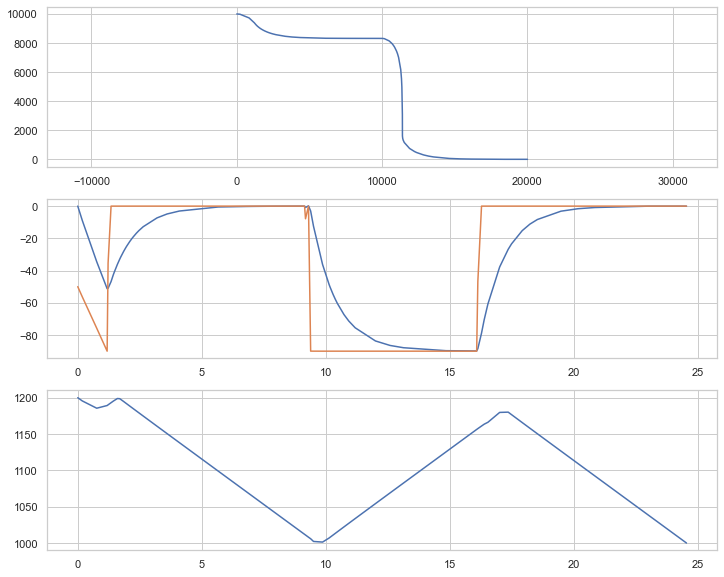

In [229]:
# Plot profile
plt.subplot(3, 1, 1)
plt.plot(x[:,2], x[:,3])
plt.axis('equal')

# Plot flight path angle
plt.subplot(3, 1, 2)
plt.plot(t, np.rad2deg(x[:,1]))
plt.plot(t, np.rad2deg(u))

# Plot velocity
plt.subplot(3, 1, 3)
plt.plot(t, x[:,0])